In [1]:
import os
import tensorflow as tf
from PIL import Image
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import random
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend, models
from tensorflow.keras.applications import MobileNet
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# for colab use
!git clone https://github.com/amitf1/Birds_Classifier.git

Cloning into 'Birds_Classifier'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 42363 (delta 30), reused 52 (delta 18), pack-reused 42296
Receiving objects: 100% (42363/42363), 1.65 GiB | 65.83 MiB/s, done.
Resolving deltas: 100% (271/271), done.
Checking out files: 100% (70805/70805), done.


In [4]:
#paths of directories on colab. 
BASE_DIR = '/content/Birds_Classifier/data'
print('BASE_DIR contains ', os.listdir(BASE_DIR))
TRAIN_DIR = os.path.join(BASE_DIR, '200_species_train')
VALIDATION_DIR = os.path.join(BASE_DIR, '200_species_valid')
TEST_DIR = os.path.join(BASE_DIR, '200_species_test')


BASE_DIR contains  ['200_species_valid', 'birds200_test', '200_species_train', '200_species_test', '200_species_consolidated', 'birds200_train']


In [6]:
#our categories.
CATEGORIES = os.listdir(TRAIN_DIR)
print(str(len(CATEGORIES)),'CATEGORIES are ', CATEGORIES)
Category_count = len(CATEGORIES)

200 CATEGORIES are  ['OSTRICH', 'VIOLET GREEN SWALLOW', 'WHITE TAILED TROPIC', 'COUCHS KINGBIRD', 'PURPLE GALLINULE', 'RAZORBILL', 'VENEZUELIAN TROUPIAL', 'TREE SWALLOW', 'WHITE NECKED RAVEN', 'MANDRIN DUCK', 'TOUCHAN', 'WILSONS BIRD OF PARADISE', 'EMPEROR PENGUIN', 'LILAC ROLLER', 'BAY-BREASTED WARBLER', 'SPLENDID WREN', 'WILD TURKEY', 'CASSOWARY', 'RUFUOS MOTMOT', 'NORTHERN JACANA', 'BLACK VULTURE', 'AMERICAN REDSTART', 'ROADRUNNER', 'BARN SWALLOW', 'FLAMINGO', 'HOODED MERGANSER', 'SORA', 'HOUSE SPARROW', 'BIRD OF PARADISE', 'AMERICAN KESTREL', 'EURASIAN MAGPIE', 'PEREGRINE FALCON', 'SCARLET MACAW', 'AFRICAN FIREFINCH', 'TOWNSENDS WARBLER', 'GOULDIAN FINCH', 'RUBY THROATED HUMMINGBIRD', 'WOOD DUCK', 'GLOSSY IBIS', 'EASTERN MEADOWLARK', 'EASTERN BLUEBIRD', 'INDIGO BUNTING', 'COCK OF THE  ROCK', 'GOLDEN CHEEKED WARBLER', 'MIKADO  PHEASANT', 'MASKED BOOBY', 'BELTED KINGFISHER', 'CHARA DE COLLAR', 'JAVAN MAGPIE', 'BROWN NOODY', 'GUINEAFOWL', 'HORNBILL', 'RED WINGED BLACKBIRD', 'GRAY PART

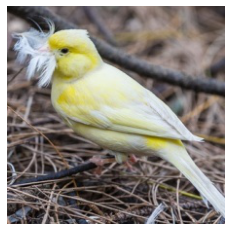

Figures are  (224, 224, 3)


In [7]:
#Load an image and determine image shape for analysis.
IMAGE = load_img(f"{TRAIN_DIR}/CANARY/001.jpg")
plt.imshow(IMAGE)
plt.axis("off")
plt.show()

IMAGEDATA = img_to_array(IMAGE)
SHAPE = IMAGEDATA.shape
print('Figures are ', SHAPE)

In [8]:
#Normalization. This will be used on training, test, and valid data
General_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
def load_dataset(data_path, max_species=200, shuffled=True, grayscale=False, flatten=False):
    data_images = []
    data_labels = []
    for num_species, specie in enumerate(os.listdir(data_path)):
        images_path = os.path.join(data_path, specie)
        for i in os.listdir(images_path):
            image_path = os.path.join(images_path, i)
            im = Image.open(image_path)
            if grayscale:
                im = im.convert("L")
            arr = np.asarray(im)
            if flatten:
                arr = arr.flatten()
            data_images.append(arr)
            data_labels.append(specie)
        if num_species == max_species - 1:
            break
    data_images = np.array(data_images)
    data_labels = np.array(data_labels)

    if shuffled:
        X, y = shuffle(data_images, data_labels, random_state=42)
    return tf.constant(X, dtype=float), tf.constant(y)

In [10]:
train_data = General_datagen.flow_from_directory(TRAIN_DIR, target_size=(224,224))
print('data groups:', len(train_data))
Train_groups = len(train_data)
validation_data = General_datagen.flow_from_directory(VALIDATION_DIR, target_size=(224,224),)
image_qty = len(validation_data.filenames)
print('data groups:', len(validation_data))
print('validation image qty:',str(image_qty))
Valid_groups = len(validation_data)
test_data = General_datagen.flow_from_directory(TEST_DIR, target_size=(224,224),)
print('data groups:', len(test_data))


# create also a regular dataset for convience in predicting later
X_val, y_val = load_dataset(VALIDATION_DIR)
X_val = X_val/255.0

Found 27503 images belonging to 200 classes.
data groups: 860
Found 1000 images belonging to 200 classes.
data groups: 32
validation image qty: 1000
Found 1000 images belonging to 200 classes.
data groups: 32


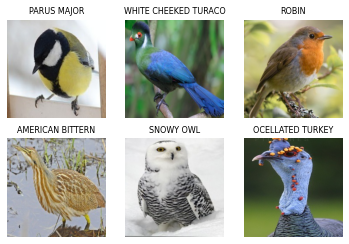

In [11]:
#create seperate labels for images 
def label_images2(DIR, dataset):
    label = []
    image = []
    j=0
    for i in range (0,30):
        j = random.randint(0, len(dataset.filenames))
        label.append(dataset.filenames[j].split('/')[0])
        image.append(DIR + '/' + dataset.filenames[j])
    return [label,image]

#plot the random images.
y,x = label_images2(TEST_DIR, test_data)

for i in range(0,6):
    X = load_img(x[i])
    plt.subplot(2,3,1 + i)
    plt.axis(False)
    plt.title(y[i], fontsize=8)
    plt.imshow(X)
plt.show()

MobileNets:


*   Model 1 - Running MobileNet with Adam and constant learning rate of 0.002.
*   Model 2 - Running MobileNet with Adam, learning rate of 0.05, fast learning decay and a Dropout regularization in the layer before the output layer



Model

In [17]:
#Let's try the mobilenet with ReduceLROnPlateau with augmentation 
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)

model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dense(Category_count)) 
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
activation (Activation)      (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               10035400  
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
Total params: 13,264,264
Trainable params: 10,035,400
Non-trainable params: 3,228,864
_________________________________________________________________


In [18]:
#Compile
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.002),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [19]:
#fit model
history = model.fit( 
    train_data, 
    batch_size = 128, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5,
                             restore_best_weights = True)])

Epoch 1/50
860/860 [==============================] - 97s 112ms/step - loss: 24.1049 - accuracy: 0.6373 - val_loss: 11.0726 - val_accuracy: 0.8390
Epoch 2/50
860/860 [==============================] - 101s 117ms/step - loss: 4.9231 - accuracy: 0.9211 - val_loss: 10.5553 - val_accuracy: 0.8690
Epoch 3/50
860/860 [==============================] - 100s 116ms/step - loss: 4.0891 - accuracy: 0.9410 - val_loss: 16.0528 - val_accuracy: 0.8400
Epoch 4/50
860/860 [==============================] - 103s 120ms/step - loss: 3.2883 - accuracy: 0.9546 - val_loss: 15.9393 - val_accuracy: 0.8660
Epoch 5/50
860/860 [==============================] - 105s 122ms/step - loss: 3.3655 - accuracy: 0.9584 - val_loss: 12.9651 - val_accuracy: 0.8840
Epoch 6/50
860/860 [==============================] - 108s 125ms/step - loss: 2.8702 - accuracy: 0.9664 - val_loss: 18.5478 - val_accuracy: 0.8700
Epoch 7/50
860/860 [==============================] - 109s 127ms/step - loss: 2.6268 - accuracy: 0.9695 - val_loss: 17

In [21]:
y_pred_val = model.predict(X_val)
enc = LabelEncoder()
y_val = enc.fit_transform(y_val)

In [22]:
y_preds = y_pred_val.argmax(axis=1)

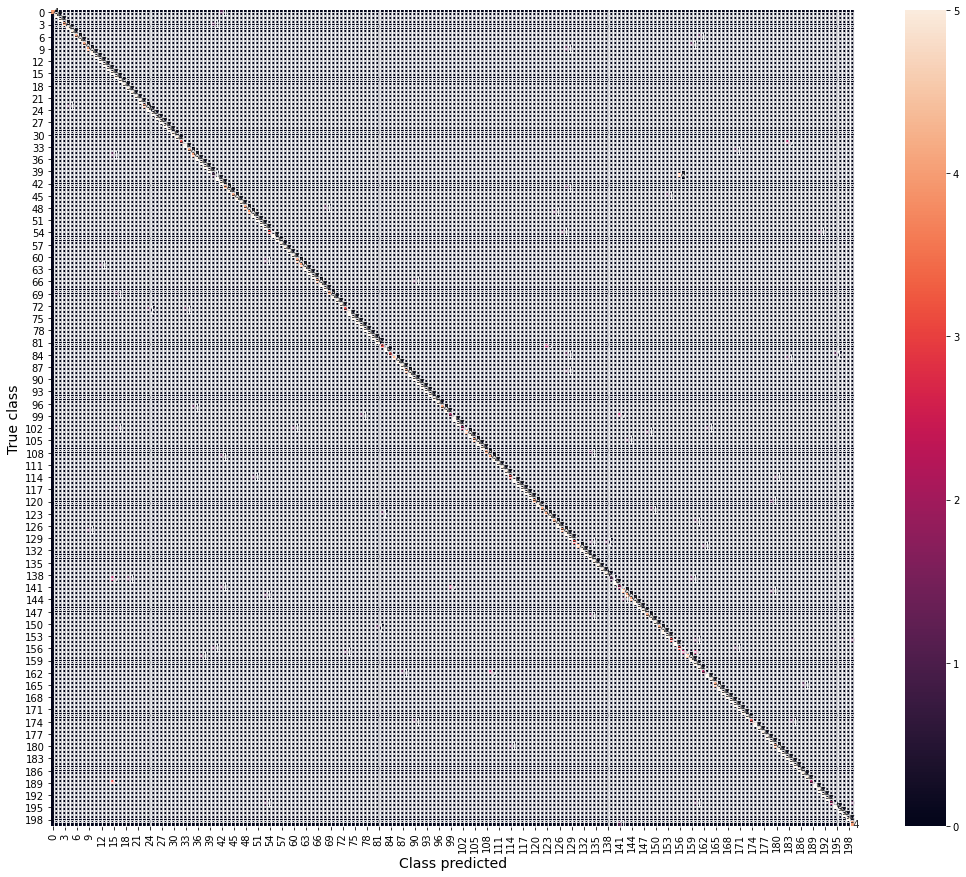

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      0.80      0.89         5
           7       1.00      1.00      1.00         5
           8       1.00      0.80      0.89         5
           9       0.80      0.80      0.80         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       0.45      1.00      0.62         5
          16       0.71      1.00      0.83         5
          17       1.00    

In [23]:
f = plt.figure(figsize=(18, 15))
sns.heatmap(confusion_matrix(y_val, y_preds), annot=True, fmt="3d")
plt.xlabel('Class predicted', fontsize=14)
plt.ylabel('True class', fontsize=14)
plt.show()

print(classification_report(y_val, y_preds))

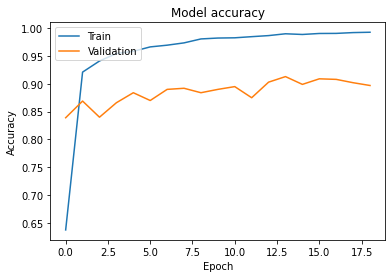

In [24]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

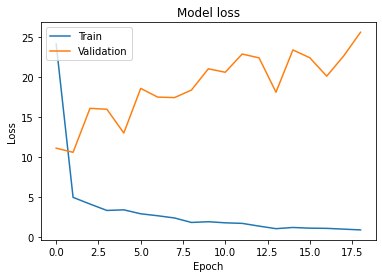

In [25]:
#plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [26]:
# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


32/32 [==============================] - 4s 130ms/step - loss: 12.2439 - accuracy: 0.9250
Test loss: 12.243884086608887
Test accuracy: 0.925000011920929


In [27]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/model1')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model/model1/assets


**Model 2** 

Adding regularization to the model

In [28]:
#Let's try the mobilenet with ReduceLROnPlateau with augmentation 
backend.clear_session()

#Bring in the imagenet dataset training weights for the Mobilenet CNN model.
#Remove the classification top.
base_mobilenet = MobileNet(weights = 'imagenet', include_top = False, 
                           input_shape = SHAPE)
base_mobilenet.trainable = False # Freeze the mobilenet weights.

model = Sequential()
model.add(base_mobilenet)
model.add(Flatten()) 
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(200))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
activation (Activation)      (None, 50176)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               10035400  
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
Total params: 13,264,264
Trainable params: 10,035,400
Non-trainable params: 3,228,864
____________________________________

In [29]:
#Compile
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.05),
               loss = 'categorical_crossentropy',
               metrics = ['accuracy'])

In [30]:
#fit model
history = model.fit( 
    train_data, 
    batch_size = 128, 
    epochs = 50,
    validation_data = validation_data,
    validation_steps = Valid_groups,
    verbose = 1,
    callbacks=[EarlyStopping(monitor = 'val_accuracy', patience = 5, 
                             restore_best_weights = True),
               ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, 
                                 patience = 2, verbose = 1)]) 
                # left verbose 1 so I could see the learning rate decay

Epoch 1/50
860/860 [==============================] - 109s 127ms/step - loss: 543.8172 - accuracy: 0.6208 - val_loss: 225.5020 - val_accuracy: 0.8470 - lr: 0.0500
Epoch 2/50
860/860 [==============================] - 116s 134ms/step - loss: 118.2465 - accuracy: 0.9125 - val_loss: 237.6938 - val_accuracy: 0.8760 - lr: 0.0500
Epoch 3/50
860/860 [==============================] - ETA: 0s - loss: 85.2825 - accuracy: 0.9401
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
860/860 [==============================] - 113s 131ms/step - loss: 85.2825 - accuracy: 0.9401 - val_loss: 331.9332 - val_accuracy: 0.8510 - lr: 0.0500
Epoch 4/50
860/860 [==============================] - 114s 133ms/step - loss: 24.1514 - accuracy: 0.9798 - val_loss: 174.5451 - val_accuracy: 0.9140 - lr: 0.0250
Epoch 5/50
860/860 [==============================] - 114s 132ms/step - loss: 12.0840 - accuracy: 0.9868 - val_loss: 180.9537 - val_accuracy: 0.9020 - lr: 0.0250
Epoch 6/50
860/860 [====

In [31]:
y_pred_val = model.predict(X_val)
enc = LabelEncoder()
y_val = enc.fit_transform(y_val)

In [32]:
y_preds = y_pred_val.argmax(axis=1)

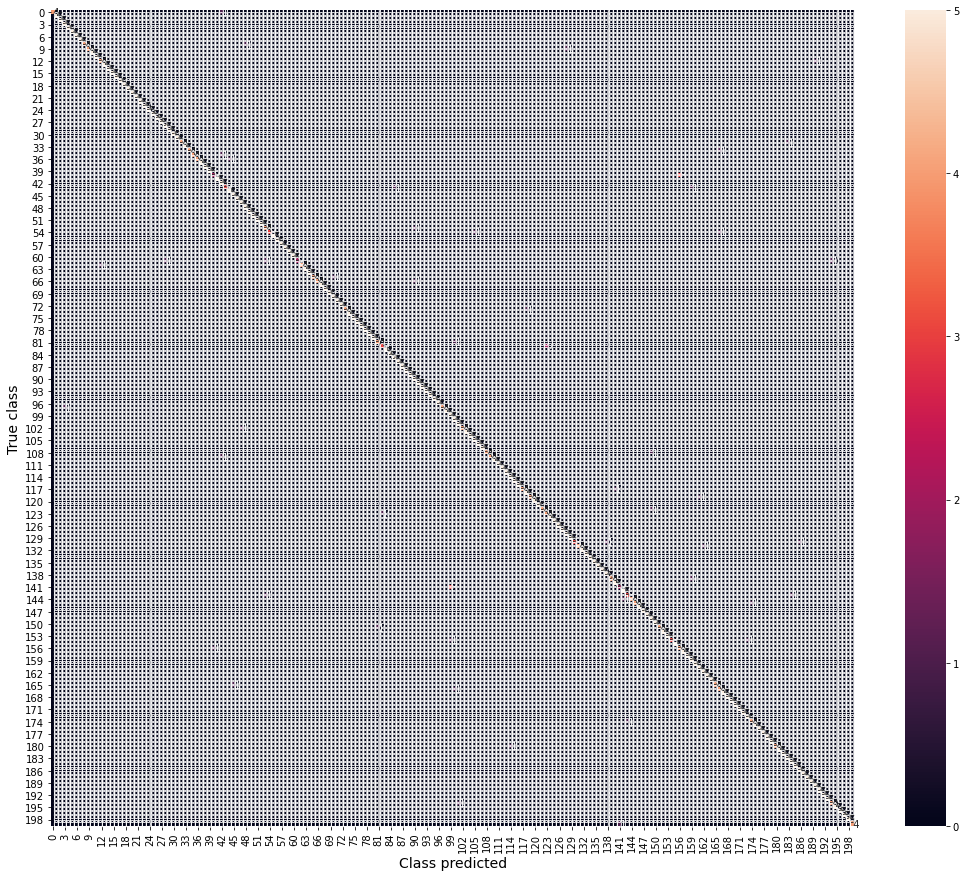

In [33]:
f = plt.figure(figsize=(18, 15))
sns.heatmap(confusion_matrix(y_val, y_preds), annot=True, fmt="3d")
plt.xlabel('Class predicted', fontsize=14)
plt.ylabel('True class', fontsize=14)
plt.show()

In [34]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      0.80      0.89         5
           9       1.00      0.80      0.89         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.80      0.80      0.80         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

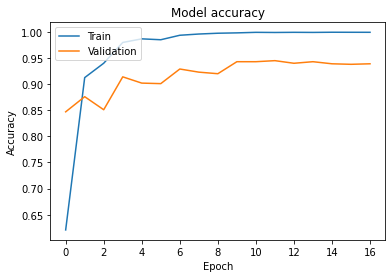

In [35]:
#plot accuracy vs epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

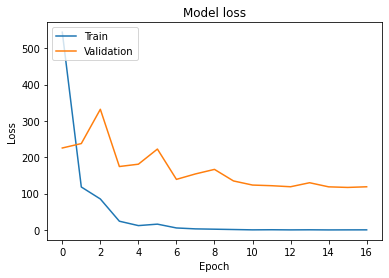

In [36]:
#plot loss vs epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
# Evaluate against test data.
scores = model.evaluate(test_data, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

32/32 [==============================] - 4s 110ms/step - loss: 75.8368 - accuracy: 0.9490
Test loss: 75.83678436279297
Test accuracy: 0.9490000009536743


In [38]:
# Evaluate against train data.
scores = model.evaluate(train_data, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1])

860/860 [==============================] - 101s 117ms/step - loss: 0.1556 - accuracy: 0.9999
Train loss: 0.1555599868297577
Train accuracy: 0.999854564666748


In [39]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/model2')

INFO:tensorflow:Assets written to: saved_model/model2/assets


In [40]:
#download my saved models to my google drive
!cp -r saved_model drive/"My Drive"/